# RoBERTa DET/ROC Curve Visualization

# 1. ROC Curve Plotting

In this notebook we will plot the DET / ROT curve.

## Background Knowledge

https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc

https://checkmyai.com/index.php?get=methods

<img src="https://checkmyai.com/images/roc.png" width="400px"/>

## Initialization

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from Model import SentinelNonLinear, Sentinel
from transformers import RobertaModel, RobertaTokenizer
from sklearn.metrics import auc

from tqdm.notebook import tqdm

In [2]:
PATH_ROOT = Path(Path.cwd().parent.parent.parent)
PATH_WEBTEXT = Path(PATH_ROOT, "data", "open-web-text-split")
PATH_GPTTEXT = Path(PATH_ROOT, "data", "open-gpt-text-split")
PATH_DIRTY_WEB = Path(PATH_ROOT, "data", "open-web-text")
PATH_DIRTY_GPT = Path(PATH_ROOT, "data", "open-gpt-text")

PATH_CACHE = Path(PATH_ROOT, "result", "cache")
PATH_FIG   = Path(PATH_ROOT, "result", "figures", "ROC")
PATH_DET_FIG = Path(PATH_ROOT, "result", "figures", "DET")

PATH_CLEAN_CHECKPT = Path(PATH_CACHE, "roberta.base.0425.pt")
PATH_DIRTY_CHECKPT = Path(PATH_CACHE, "roberta.base.0406.pt")

In [3]:
class DualDataset(torch.utils.data.Dataset):
    def __init__(self, webTextPath: str, gptTextPath: str) -> None:
        super().__init__()

        # load from filesystem

        gptText = pd.read_json(gptTextPath, lines=True)['text']
        gptUID  = pd.read_json(gptTextPath, lines=True)['uid']
        all_uids = {uid for uid in gptUID}

        webData = pd.read_json(webTextPath, lines=True)
        webData = webData.loc[webData['uid'].isin(all_uids)]
        webText = webData["text"]
        webUID  = webData["uid"]

        # label accordingly
        self.data = [(text, 0) for text in webText] + [(text, 1) for text in gptText]
        self.uid  = [(uid, 0) for uid in webUID] + [(uid, 1) for uid in gptUID]
        self.length = len(self.data)

    def __len__(self):
        return self.length

    def __getitem__(self, index: int):
        return self.data[index], self.uid[index]

In [4]:
checkpoint = torch.load(PATH_CLEAN_CHECKPT, map_location="cpu")
print(checkpoint.keys())

dict_keys(['epochIter', 'model', 'optimizer', 'scheduler', 'validAccuracy', 'testAccuracy'])


Now we want to load our model and setup the dataset

In [6]:
clean_model = SentinelNonLinear(
    RobertaModel.from_pretrained("roberta-base"),
    RobertaTokenizer.from_pretrained("roberta-base")
)

print("Loading model with validation accuracy", checkpoint["validAccuracy"])
clean_model.load_state_dict(checkpoint["model"])
clean_model = clean_model.to("cuda")
clean_model.eval()

clean_dataset = DualDataset(
    webTextPath=str(Path(PATH_WEBTEXT, "test.jsonl")),
    gptTextPath=str(Path(PATH_GPTTEXT, "test.jsonl"))
)
dirty_dataset = DualDataset(
    webTextPath=str(Path(PATH_DIRTY_WEB, "urlsf_subset04.jsonl")),
    gptTextPath=str(Path(PATH_DIRTY_GPT, "urlsf_subset04.jsonl"))
)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loading model with validation accuracy 0.9367814590301002


## Clean model visualization

The "clean" model is the model trained on normalized dataset. We will first calculate the probability pair for every element in the test dataset

In [7]:
clean_prediction_cache_path = Path(PATH_CACHE, "clean_model_pred_clean_data.pt")

if clean_prediction_cache_path.exists():
    print("Using existing cache")
    prediction_result = torch.load(clean_prediction_cache_path)
else:
    print("Doesn't find existing cache, rerun the model")
    # Prediction result is a list
    prediction_result = dict()

    for index in tqdm(range(len(clean_dataset))):
        (text, label), (uid, _) = clean_dataset[index]
        uid += "-web" if label == 0 else "-gpt"

        pred: torch.Tensor = clean_model(text)
        pred = torch.nn.functional.softmax(pred, dim=-1)
        pred = pred.detach().cpu().numpy().flatten()
        prediction_result[uid] = pred

    torch.save(prediction_result, clean_prediction_cache_path)

Doesn't find existing cache, rerun the model


  0%|          | 0/4213 [00:00<?, ?it/s]

In [8]:
def calculate_ROC(prediction, threshold):
    # Positive -> Real, Negative -> Fake
    TP, TN, FP, FN = 0, 0, 0, 0
    for key in prediction:
        label = key.endswith("web")
        y_hat = prediction[key][0] > threshold

        if label == True and y_hat == True: TP += 1
        elif label == True and y_hat == False: FN += 1
        elif label == False and y_hat == True: FP += 1
        else: TN += 1
    return TP, TN, FP, FN

print("Statistics under standard threshold (p = 0.5)", calculate_ROC(prediction_result, 0.5))

Statistics under standard threshold (p = 0.5) (1161, 2850, 94, 108)


### "Clean Model" on "Clean Dataset" ROC Curve

In [9]:
def calcROCCurve(prediction, start=0, end=1, precision=0.01):
    TPs, TNs, FPs, FNs = [], [], [], []
    TPRs, FPRs = [], []
    for thresh in tqdm(range(start, int(end / precision))):
        thresh = thresh * precision
        TP, TN, FP, FN = calculate_ROC(prediction, thresh)
        TPs.append(TP)
        TNs.append(TN)
        FPs.append(FP)
        FNs.append(FN)
        TPRs.append(TP / (TP + FN))
        FPRs.append(FP / (FP + TN))
    return TPRs, FPRs, [TPs, TNs, FPs, FNs]

In [10]:
clean_TPRs, clean_FPRs, _ = calcROCCurve(prediction_result)

  0%|          | 0/100 [00:00<?, ?it/s]

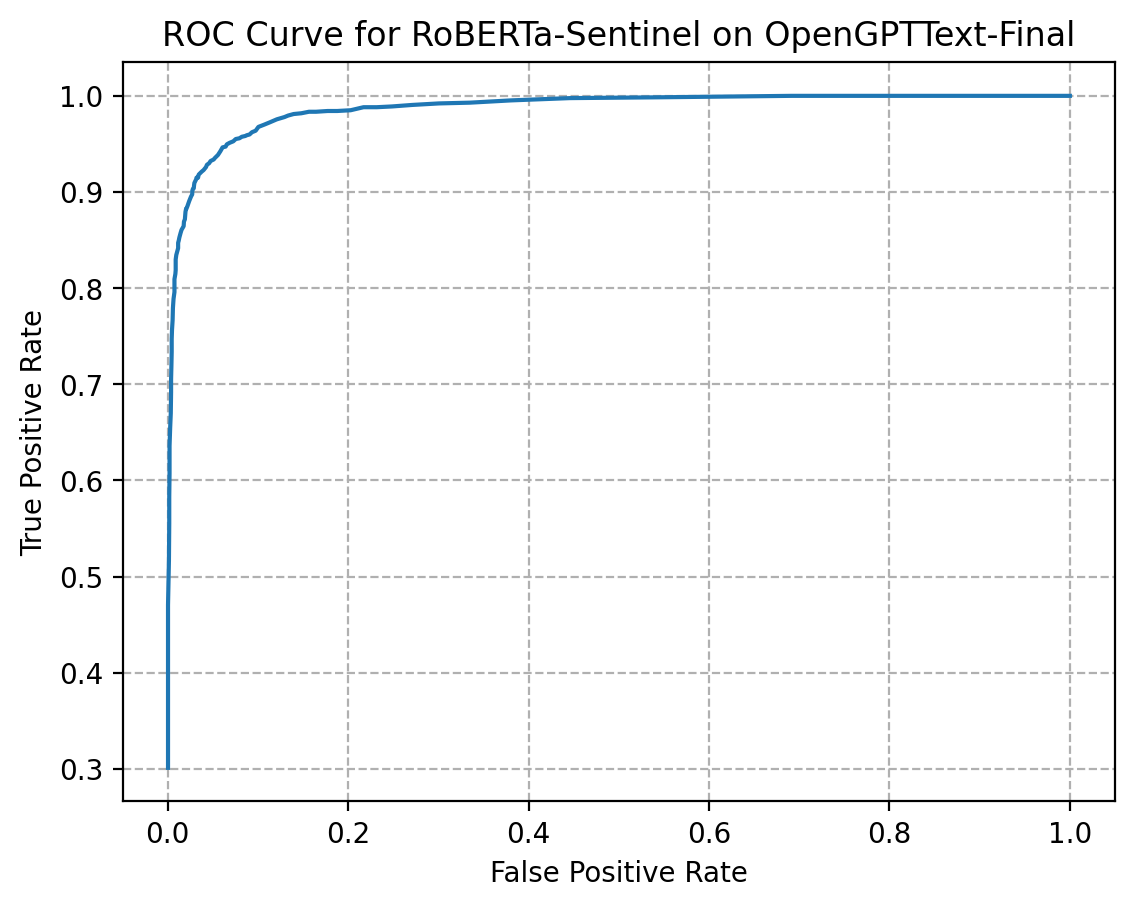

In [11]:
def plotROCCurve(TPRs, FNRs, fileName, title):
    fig: plt.Figure = plt.figure(dpi=200)
    FPR_arr = np.array(FNRs)
    TPR_arr = np.array(TPRs)
    ax: plt.Axes = fig.add_subplot(1, 1, 1)
    ax.plot(FPR_arr, TPR_arr, label="ROC Curve")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(title)
    ax.grid(linestyle="--")
    plt.show()
    fig.savefig(Path(PATH_FIG, fileName))

plotROCCurve(
    clean_TPRs, clean_FPRs,
    "Roberta_ROC_Curve-cleanModel-cleanData.pdf",
    "ROC Curve for RoBERTa-Sentinel on OpenGPTText-Final"
)

### "Clean Model" on "Dirty Dataset" ROC Curve

In [13]:
clean_prediction_cache_path = Path(PATH_CACHE, "clean_model_pred_dirty_data.pt")

if clean_prediction_cache_path.exists():
    print("Using existing cache")
    prediction_result = torch.load(clean_prediction_cache_path)
else:
    print("Doesn't find existing cache, rerun the model")
    # Prediction result is a list
    prediction_result = dict()

    for index in tqdm(range(len(dirty_dataset))):
        (text, label), (uid, _) = dirty_dataset[index]
        uid += "-web" if label == 0 else "-gpt"

        pred: torch.Tensor = clean_model(text)
        pred = torch.nn.functional.softmax(pred, dim=-1)
        pred = pred.detach().cpu().numpy().flatten()
        prediction_result[uid] = pred

    torch.save(prediction_result, clean_prediction_cache_path)

Doesn't find existing cache, rerun the model


  0%|          | 0/7368 [00:00<?, ?it/s]

In [14]:
dirty_TPRs, dirty_FPRs, _ = calcROCCurve(prediction_result)

  0%|          | 0/100 [00:00<?, ?it/s]

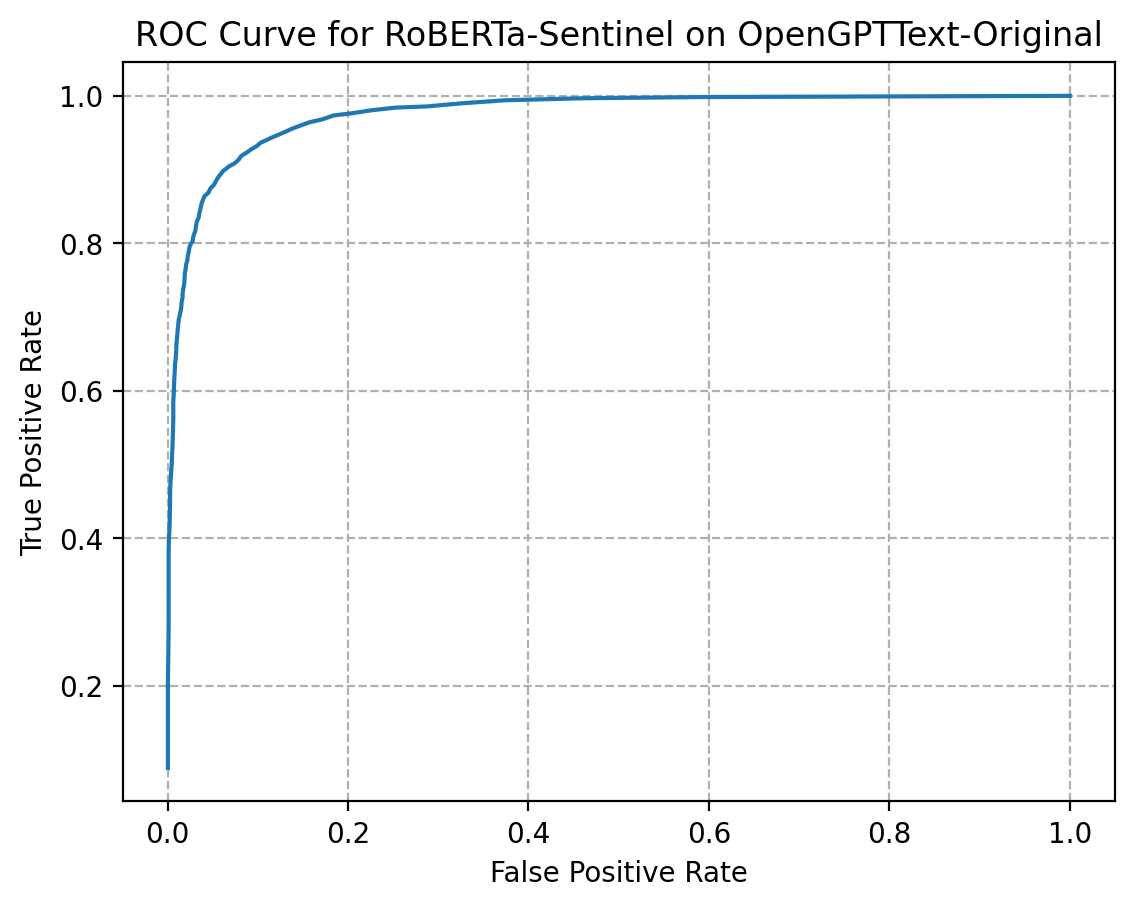

In [15]:
plotROCCurve(
    dirty_TPRs, dirty_FPRs,
    "Roberta_ROC_Curve-cleanModel-dirtyData.pdf",
    "ROC Curve for RoBERTa-Sentinel on OpenGPTText-Original"
)

### Plot two curves together

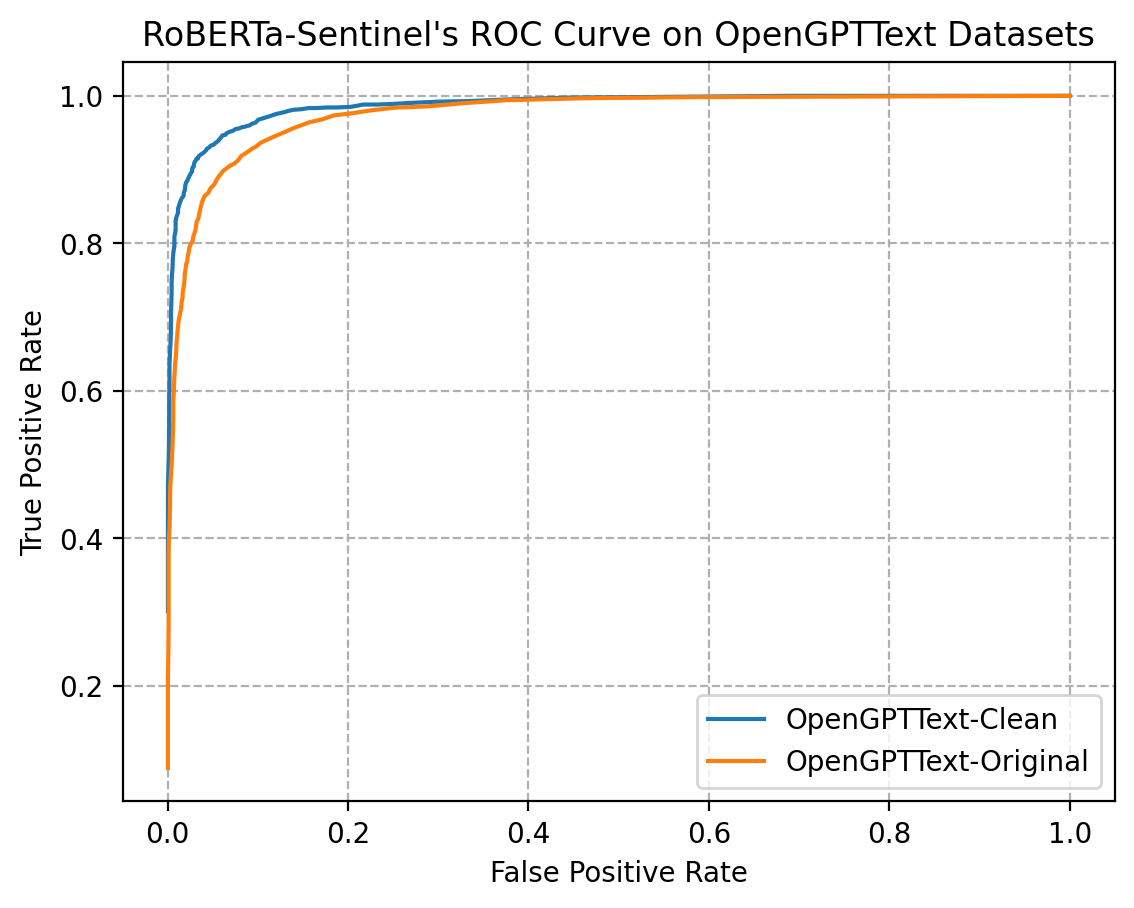

In [16]:
combined_curve_path = Path(PATH_FIG, "Roberta_ROC_Curve-cleanModel.pdf")
fig: plt.Figure = plt.figure(dpi=200)
ax: plt.Axes = fig.add_subplot(1, 1, 1)
ax.plot(clean_FPRs, clean_TPRs, label="OpenGPTText-Clean")
ax.plot(dirty_FPRs, dirty_TPRs, label="OpenGPTText-Original")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.grid(linestyle="--")
ax.legend()
ax.set_title("RoBERTa-Sentinel's ROC Curve on OpenGPTText Datasets")
fig.savefig(combined_curve_path)

### Estimate the Area Under Curve (AUC) for Clean Model

In [ ]:
print("Clean Model on Clean Data AUC:", auc(clean_FPRs, clean_TPRs))
print("Clean Model on Dirty Data AUC:", auc(dirty_FPRs, dirty_TPRs))

## Evaluate Dirty Model

In [ ]:
del clean_model
torch.cuda.empty_cache()

In [ ]:
checkpoint = torch.load(PATH_DIRTY_CHECKPT, map_location="cpu")
dirty_model = Sentinel(
    RobertaModel.from_pretrained("roberta-base"),
    RobertaTokenizer.from_pretrained("roberta-base")
)

print("Loading model with validation accuracy", checkpoint["validAccuracy"])
dirty_model.load_state_dict(checkpoint["model"])
dirty_model = dirty_model.to("cuda")
dirty_model.eval()

### Dirty Model on Clean Dataset

In [ ]:
clean_prediction_cache_path = Path(PATH_CACHE, "dirty_model_pred_clean_data.pt")

if clean_prediction_cache_path.exists():
    print("Using existing cache")
    prediction_result = torch.load(clean_prediction_cache_path)
else:
    print("Doesn't find existing cache, rerun the model")
    # Prediction result is a list
    prediction_result = dict()

    for index in tqdm(range(len(clean_dataset))):
        (text, label), (uid, _) = clean_dataset[index]
        uid += "-web" if label == 0 else "-gpt"

        pred: torch.Tensor = dirty_model(text)
        pred = torch.nn.functional.softmax(pred, dim=-1)
        pred = pred.detach().cpu().numpy().flatten()
        prediction_result[uid] = pred

    torch.save(prediction_result, clean_prediction_cache_path)



In [ ]:
dM_clean_TPRs, dM_clean_FPRs, _ = calcROCCurve(prediction_result)

In [ ]:
plotROCCurve(
    dM_clean_TPRs, dM_clean_FPRs,
    "Roberta_ROC_Curve-dirtyModel-cleanData.png",
    "ROC Curve for Dirty RoBERTa on Clean-OpenGPTText"
)

### Dirty Model on Dirty Data

In [ ]:
dirty_prediction_cache_path = Path(PATH_CACHE, "dirty_model_pred_dirty_data.pt")

if dirty_prediction_cache_path.exists():
    print("Using existing cache")
    prediction_result = torch.load(dirty_prediction_cache_path)
else:
    print("Doesn't find existing cache, rerun the model")
    # Prediction result is a list
    prediction_result = dict()

    for index in tqdm(range(len(dirty_dataset))):
        (text, label), (uid, _) = dirty_dataset[index]
        uid += "-web" if label == 0 else "-gpt"

        pred: torch.Tensor = dirty_model(text)
        pred = torch.nn.functional.softmax(pred, dim=-1)
        pred = pred.detach().cpu().numpy().flatten()
        prediction_result[uid] = pred

    torch.save(prediction_result, dirty_prediction_cache_path)


In [ ]:
dM_dirty_TPRs, dM_dirty_FPRs, _ = calcROCCurve(prediction_result)

In [ ]:
plotROCCurve(
    dM_dirty_TPRs, dM_dirty_FPRs,
    "Roberta_ROC_Curve-dirtyModel-dirtyData.png",
    "ROC Curve for Dirty RoBERTa on Dirty-OpenGPTText"
)

### Compare Dirty Model's Performance on Both Datasets

In [ ]:
combined_curve_path = Path(PATH_FIG, "Roberta_ROC_Curve-dirtyModel.png")
fig: plt.Figure = plt.figure(dpi=200)
ax: plt.Axes = fig.add_subplot(1, 1, 1)
ax.plot(dM_clean_FPRs, dM_clean_TPRs, label="Clean Dataset")
ax.plot(dM_dirty_FPRs, dM_dirty_TPRs, label="Dirty Dataset")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.grid(linestyle="--")
ax.legend()
ax.set_title("Dirty RoBERTa's ROC Curve on OpenGPTText Datasets")
fig.savefig(combined_curve_path)

### AUC Estimation for Dirty Model

In [ ]:
print("Dirty Model on Clean Data AUC:", auc(dM_clean_FPRs, dM_clean_TPRs))
print("Dirty Model on Dirty Data AUC:", auc(dM_dirty_FPRs, dM_dirty_TPRs))

# 2. DET Curve Plotting

In [17]:
def calcDETCurve(prediction, start=0, end=1, precision=0.01):
    TPs, TNs, FPs, FNs = [], [], [], []
    FPRs, FNRs = [], []
    for thresh in tqdm(range(start, int(end / precision))):
        thresh = thresh * precision
        TP, TN, FP, FN = calculate_ROC(prediction, thresh)
        TPs.append(TP)
        TNs.append(TN)
        FPs.append(FP)
        FNs.append(FN)
        FPRs.append(FP / (FP + TN))
        FNRs.append(FN / (FN + TP))
    return FNRs, FPRs, [TPs, TNs, FPs, FNs]

def plotDETCurve(FNRs, FPRs, fileName, title):
    fig: plt.Figure = plt.figure(dpi=200)
    FNR_arr = np.array(FNRs)
    FPR_arr = np.array(FPRs)
    ax: plt.Axes = fig.add_subplot(1, 1, 1)
    ax.plot(FPR_arr, FNR_arr, label="DET Curve")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("False Negative Rate")
    ax.set_yscale('log')
    ax.set_xscale('log')
    # ax.set_xlim(1e-3, 1)
    # ax.set_ylim(1e-3, 1)
    ticks_to_use = [0.001,0.002,0.005,0.01,0.02,0.05,0.1,0.2,0.5,1]
    ax.set_xticks(ticks_to_use)
    ax.set_yticks(ticks_to_use)
    ax.grid(linestyle="--")
    ax.set_title(title)
    plt.show()
    fig.savefig(Path(PATH_DET_FIG, fileName))

In [18]:
cM_cD_cache = Path(PATH_CACHE, "clean_model_pred_clean_data.pt")
cM_dD_cache = Path(PATH_CACHE, "clean_model_pred_dirty_data.pt")

# dM_cD_cache = Path(PATH_CACHE, "dirty_model_pred_clean_data.pt")
# dM_dD_cache = Path(PATH_CACHE, "dirty_model_pred_dirty_data.pt")

assert cM_cD_cache.exists()
assert cM_dD_cache.exists()
# assert dM_cD_cache.exists()
# assert dM_dD_cache.exists()

cM_cD_pred = torch.load(cM_cD_cache)
cM_dD_pred = torch.load(cM_dD_cache)
# dM_cD_pred = torch.load(dM_cD_cache)
# dM_dD_pred = torch.load(dM_dD_cache)

## Clean Model DET Visualization

In [23]:
cMcD_FNR, cMcD_FPR, _ = calcDETCurve(cM_cD_pred, precision=0.001)
cMdD_FNR, cMdD_FPR, _ = calcDETCurve(cM_dD_pred, precision=0.001)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

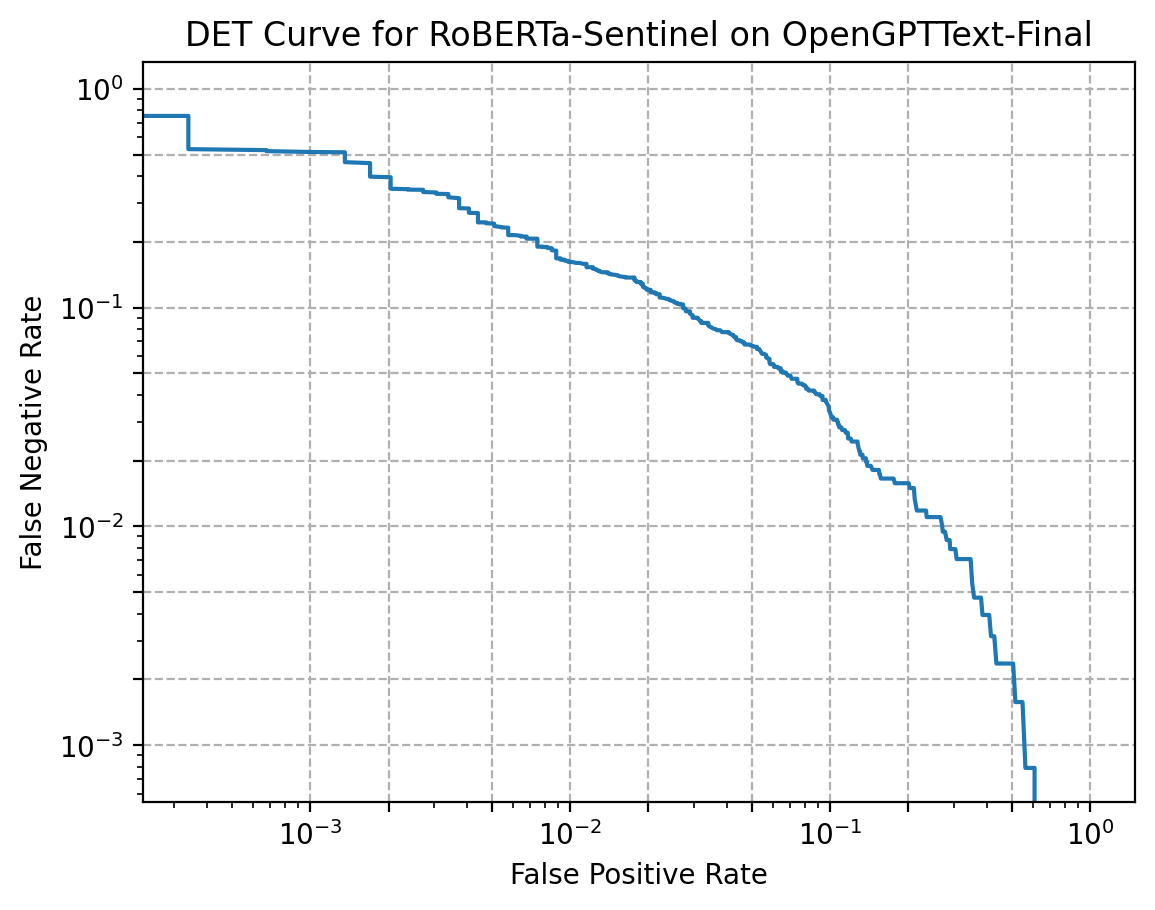

In [24]:
plotDETCurve(cMcD_FNR, cMcD_FPR, "RoBERTa_DET_Curve_cleanModel_cleanData.pdf", "DET Curve for RoBERTa-Sentinel on OpenGPTText-Final")

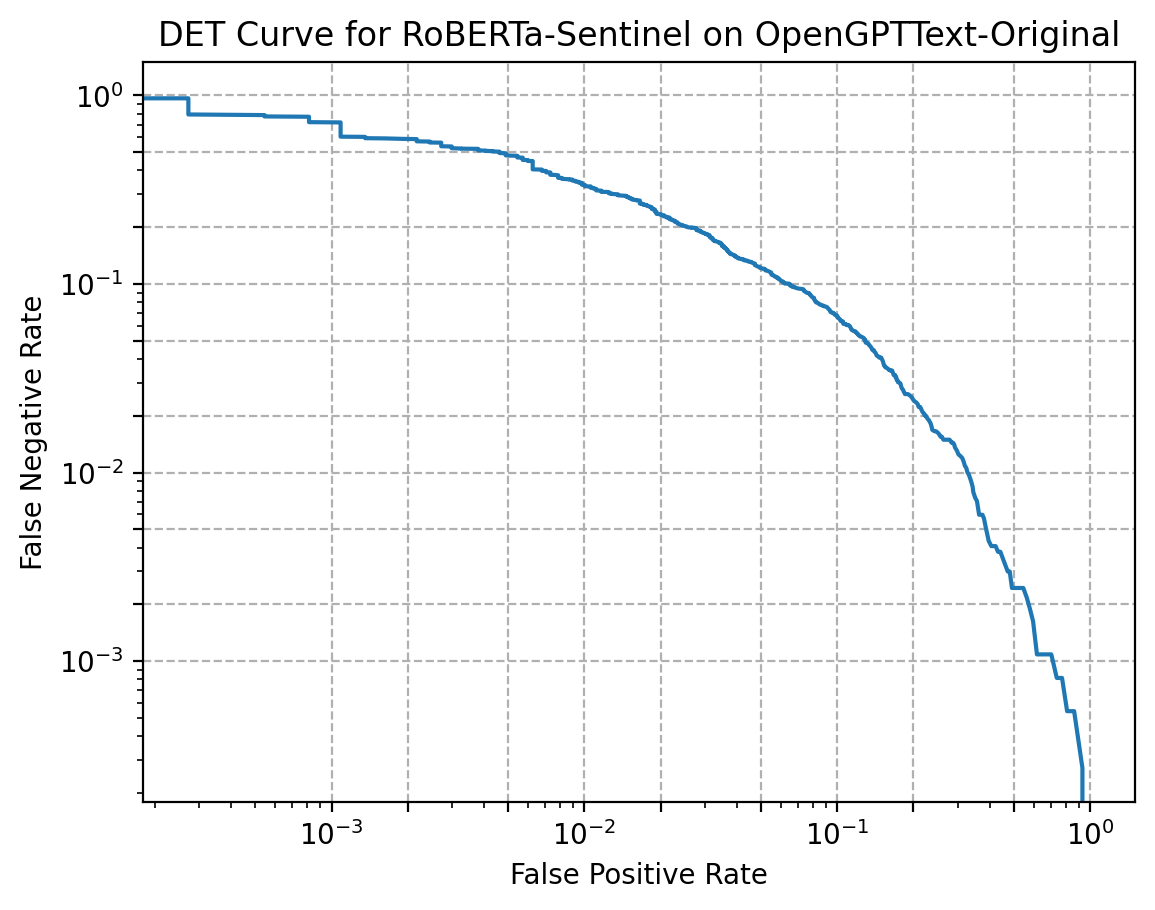

In [25]:
plotDETCurve(cMdD_FNR, cMdD_FPR, "RoBERTa_DET_Curve_cleanModel_dirtyData.pdf", "DET Curve for RoBERTa-Sentinel on OpenGPTText-Original")

### Draw Both DET Curves on Clean Model

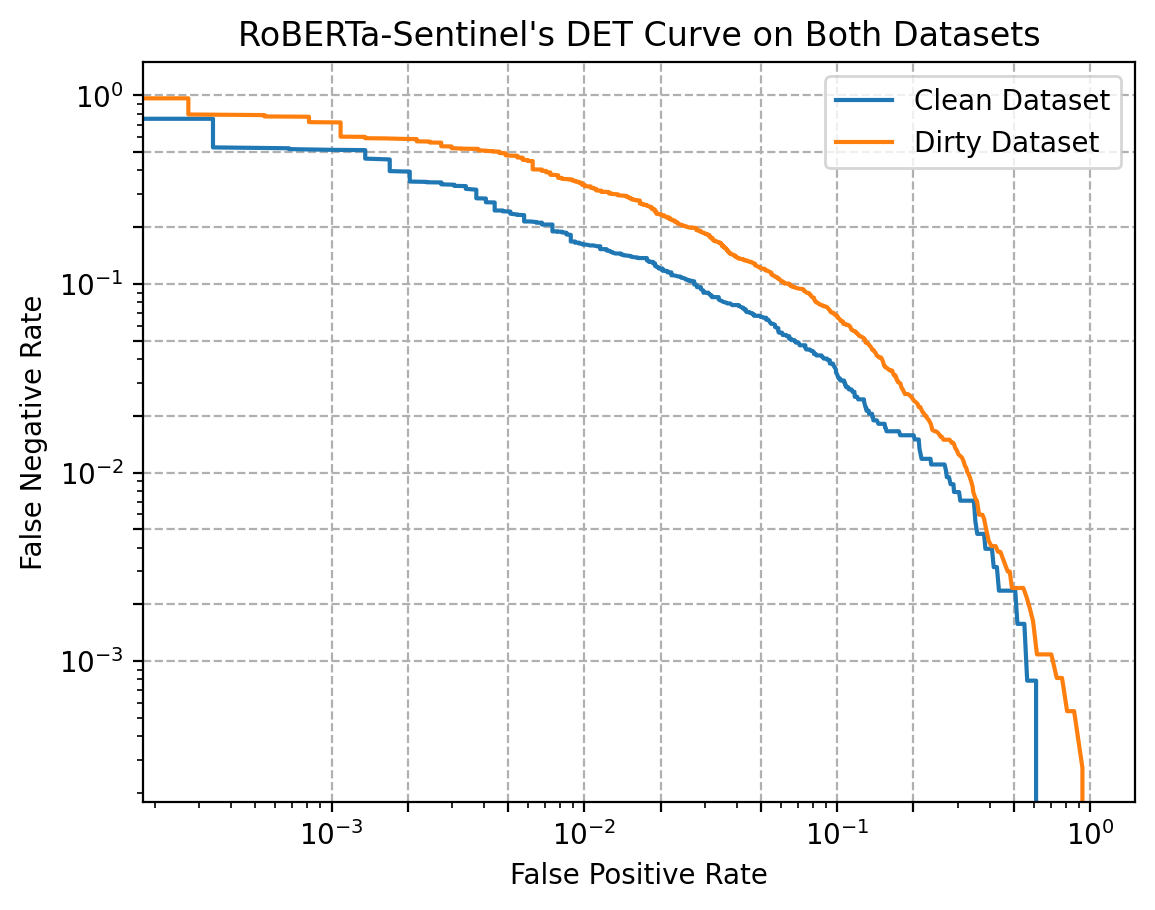

In [27]:
fig: plt.Figure = plt.figure(dpi=200)
ax: plt.Axes = fig.add_subplot(1, 1, 1)
ax.plot(cMcD_FPR, cMcD_FNR, label="Clean Dataset")
ax.plot(cMdD_FPR, cMdD_FNR, label="Dirty Dataset")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("False Negative Rate")
ax.set_yscale('log')
ax.set_xscale('log')
ticks_to_use = [0.001,0.002,0.005,0.01,0.02,0.05,0.1,0.2,0.5,1]
ax.set_xticks(ticks_to_use)
ax.set_yticks(ticks_to_use)
ax.grid(linestyle="--")
ax.set_title("RoBERTa-Sentinel's DET Curve on Both Datasets")
ax.legend()
plt.show()
fig.savefig(Path(PATH_DET_FIG, "RoBERTa_DET_Curve-cleanModel.pdf"))

## Dirty Model DET Visualization

In [ ]:
dMcD_FNR, dMcD_FPR, _ = calcDETCurve(dM_cD_pred)
dMdD_FNR, dMdD_FPR, _ = calcDETCurve(dM_dD_pred)

In [ ]:
plotDETCurve(dMcD_FNR, dMcD_FPR, "RoBERTa_DET_Curve_dirtyModel_cleanData.png", "DET Curve for Dirty RoBERTa on Clean OpenGPTText")

In [ ]:
plotDETCurve(dMdD_FNR, dMdD_FPR, "RoBERTa_DET_Curve_dirtyModel_dirtyData.png", "DET Curve for Dirty RoBERTa on Dirty OpenGPTText")

### Plot Both DET Curves for Dirty Model

In [ ]:
fig: plt.Figure = plt.figure(dpi=200)
ax: plt.Axes = fig.add_subplot(1, 1, 1)
ax.plot(dMcD_FPR, dMcD_FNR, label="Clean Dataset")
ax.plot(dMdD_FPR, dMdD_FNR, label="Dirty Dataset")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("False Negative Rate")
ax.set_yscale('log')
ax.set_xscale('log')
ticks_to_use = [0.001,0.002,0.005,0.01,0.02,0.05,0.1,0.2,0.5,1]
ax.set_xticks(ticks_to_use)
ax.set_yticks(ticks_to_use)
ax.grid(linestyle="--")
ax.set_title("Dirty RoBERTa's DET Curve on OpenGPTText Datasets")
ax.legend()
plt.show()
fig.savefig(Path(PATH_DET_FIG, "RoBERTa_DET_Curve-dirtyModel.png"))

# Combined Plots

### DET Curves

In [ ]:
fig: plt.Figure = plt.figure(dpi=200)
ax: plt.Axes = fig.add_subplot(1, 1, 1)
ax.plot(cMcD_FPR, cMcD_FNR, "b-", label="Clean Model, Clean Dataset")
ax.plot(cMdD_FPR, cMdD_FNR, "r-", label="Clean Model, Dirty Dataset")
ax.plot(dMcD_FPR, dMcD_FNR, "b--", label="Dirty Model, Clean Dataset")
ax.plot(dMdD_FPR, dMdD_FNR, "r--", label="Dirty Model, Dirty Dataset")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("False Negative Rate")
ax.set_yscale('log')
ax.set_xscale('log')
ticks_to_use = [0.001,0.002,0.005,0.01,0.02,0.05,0.1,0.2,0.5,1]
ax.set_xticks(ticks_to_use)
ax.set_yticks(ticks_to_use)
ax.grid(linestyle="--")
ax.set_title("RoBERTa's DET Curves on OpenGPTText Datasets")
ax.legend()
plt.show()
fig.savefig(Path(PATH_DET_FIG, "RoBERTa_DET_Curve.png"))

### ROC Curves

In [ ]:
cM_cD_TPRs, cM_cD_FPRs, _ = calcROCCurve(cM_cD_pred)
cM_dD_TPRs, cM_dD_FPRs, _ = calcROCCurve(cM_dD_pred)
dM_cD_TPRs, dM_cD_FPRs, _ = calcROCCurve(dM_cD_pred)
dM_dD_TPRs, dM_dD_FPRs, _ = calcROCCurve(dM_dD_pred)

In [ ]:
fig: plt.Figure = plt.figure(dpi=200)
ax: plt.Axes = fig.add_subplot(1, 1, 1)
ax.plot(cM_cD_FPRs, cM_cD_TPRs, "r-", label="Clean Model, Clean Dataset")
ax.plot(cM_dD_FPRs, cM_dD_TPRs, "b-", label="Clean Model, Dirty Dataset")
ax.plot(dM_cD_FPRs, dM_cD_TPRs, "r--", label="Dirty Model, Clean Dataset")
ax.plot(dM_dD_FPRs, dM_dD_TPRs, "b--", label="Dirty Model, Dirty Dataset")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.grid(linestyle="--")
ax.legend()
ax.set_title("RoBERTa's ROC Curves on OpenGPTText Datasets")
fig.savefig(Path(PATH_FIG, "RoBERTa_ROC_Curve.png"))